In [1]:
import pandas as pd
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization, Input, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import tensorflowjs as tfjs
from sklearn.preprocessing import OneHotEncoder
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2024-09-15 19:46:21.798855: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-15 19:46:21.807047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-15 19:46:21.875870: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-15 19:46:21.968980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 19:46:22.046675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# Read in Y labels from CSV

label_csv = 'english.csv'
df_Y = pd.read_csv(label_csv)

In [3]:
# Read images and write with label to arrays

images_path = "/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha_Handwritten_Character_Recognation/Img"
images = []
labels = []

for image_path in os.listdir(images_path):
    image = cv.imread(os.path.join(images_path, image_path)).astype('float32') 
    image = cv.resize(image, (64, 64))
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 
    image /= 255.0 # Normalise data
    
    label_index = os.path.join("Img", image_path)
    label = df_Y[df_Y['image'] == label_index].label.values[0]

    images.append(image)
    labels.append(label)

In [4]:
# Convert to np arrays

images = np.array(images)
labels = np.array(labels)

In [5]:
# Visualise images
images = np.expand_dims(images, axis=-1)

In [6]:
encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

In [7]:
# Define a custom decoder
decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

In [8]:
# Randomly shuffle the data
images, labels = shuffle(images, labels, random_state=0)

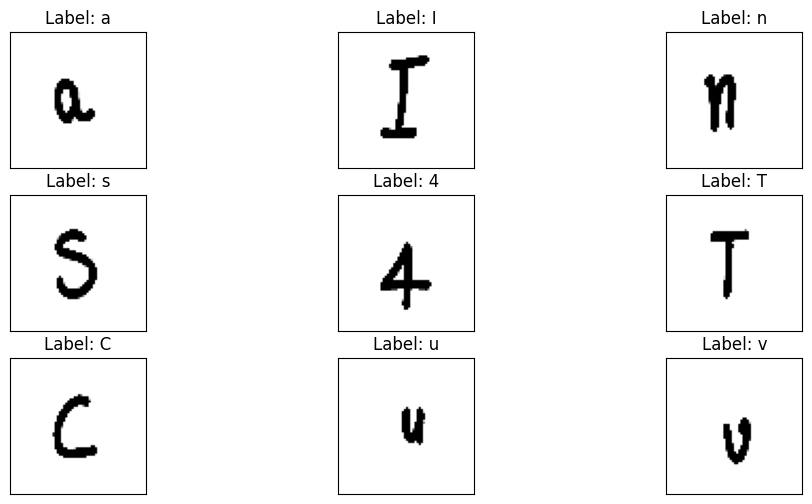

In [9]:
def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")
        
display_images(3, 3, images, labels, decoder)

In [10]:
# Split data into train, validation and test
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

In [11]:
# Define augmentation generator

datagen = ImageDataGenerator(
    rotation_range=15,    
    width_shift_range=0.1,  
    height_shift_range=0.2,
    zoom_range= 0.2, 
    shear_range=0.2,               
    fill_mode='nearest',        
)

In [12]:
# Load augmented data into arrays

augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

for i in range(len(X_train)):

    for j in range(number_of_augmentation):
        augmented_data = datagen.flow(np.expand_dims(X_train[i], axis=0), batch_size=1)
        augmented_image = next(augmented_data)[0].astype('float32')
        augmented_arr_X.append(augmented_image)
        augmented_arr_Y.append(Y_train[i])

In [13]:
# Set augmented data up for training

X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [14]:
# Shuffle again
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

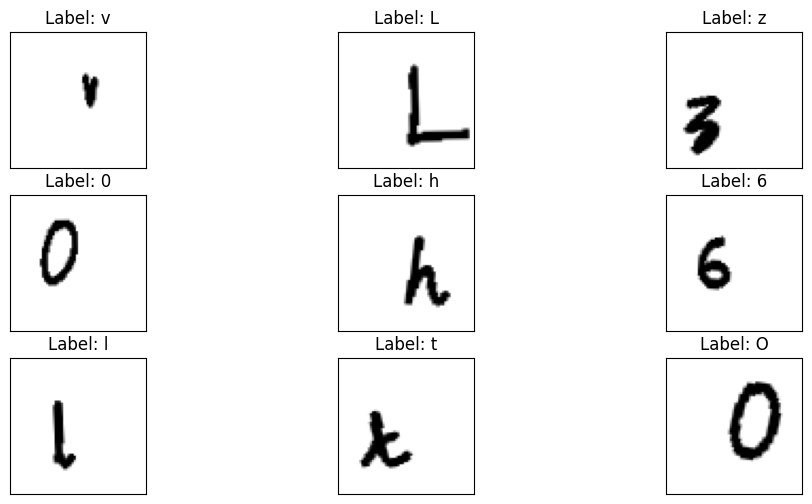

In [15]:
# Display augmented images

display_images(3, 3, X_train, Y_train, decoder)

In [16]:
# Define model

model = Sequential([
    Input(shape=(64, 64, 1)),
    Conv2D(512, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='sigmoid'),
    Dense(62, activation='softmax')
])

I0000 00:00:1726451242.076967  300246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-15 19:47:22.078156: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
# Visualise model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 512)    │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,699,774 (29.37 MB)

 Trainable params: 7,699,774 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile and train the model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
 69/373 ━━━━━━━━━━━━━━━━━━━━ 5:03 998ms/step - accuracy: 0.0156 - loss: 4.1891

In [21]:
# Train and validation accuracy

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

[]

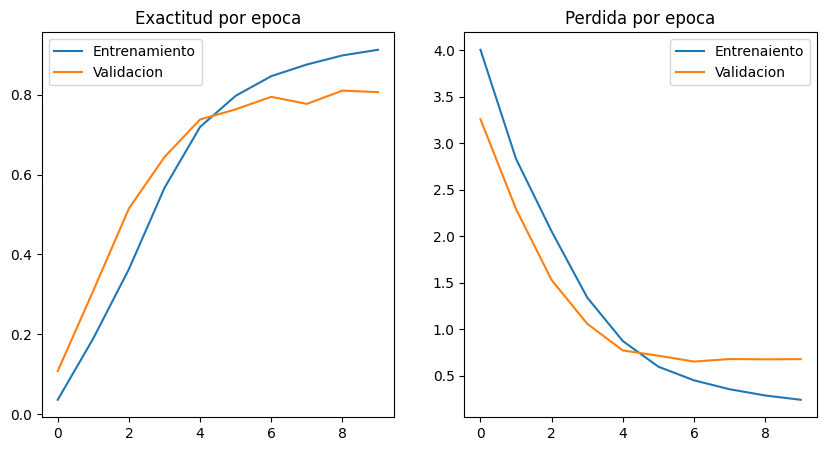

In [34]:
# Plot the accuracy and loss

_, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

# Plot accuracy
axes[0].plot(train_accuracy)
axes[0].plot(validation_accuracy)
axes[0].legend(['Entrenamiento', 'Validacion'])
axes[0].set_title("Exactitud por epoca")

# Plot loss
axes[1].plot(train_loss)
axes[1].plot(validation_loss)
axes[1].legend(['Entrenaiento', 'Validacion'])
axes[1].set_title("Perdida por epoca")

plt.plot()

In [23]:
# Get test predictions

Y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


In [24]:
# Find accuracy of the model

y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8027


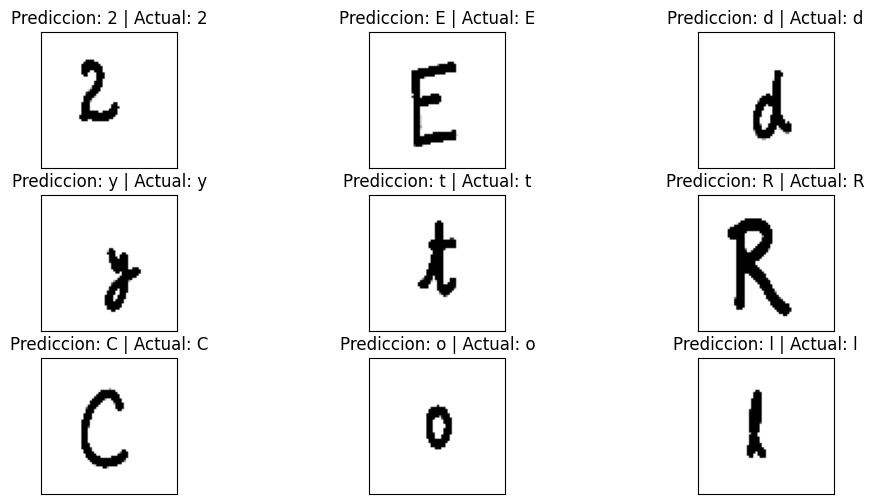

In [31]:
_, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Prediccion: {decoder[y_pred_classes[i]]} | Actual: {decoder[y_true[i]]}")

In [33]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.7783 - loss: 0.7921
Validation Loss: 0.6770939826965332
Validation Accuracy: 0.8062622547149658


In [27]:
# Save model to tfjs format and save as zip

# Save to tfjs format
tfjs.converters.save_keras_model(model, 'modelo')

# Convert output folder to zip
folder_to_zip = 'modelo'  
output_zip = 'modelo'  
shutil.make_archive(output_zip, 'zip', folder_to_zip)

failed to lookup keras version from the file,
    this is likely a weight only file


'/mnt/c/Users/leoni/Desktop/CodeAlpha/CodeAlpha_Handwritten_Character_Recognation/model_js.zip'